In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


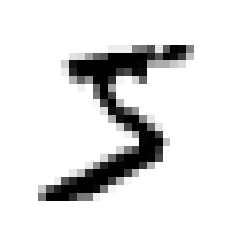

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures
## Measuring Accuracy Using Cross-Validation
### Implementing Cross-Validation

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [11]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

In [12]:
# from sklearn.base import BaseEstimator

# class Never5Classifier(BaseEstimator):
#     def fit(self, X, y=None):
#         return self
#     def predict(self, X):
#         return np.zeros((len(X)), dtype=bool)

In [13]:
# never_5_clf = Never5Classifier()
# cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

## Confusion Matrix

In [14]:
# Prepare the predictions
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
y_train_perfect_predictions = y_train_5 # Pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score

print( precision_score(y_train_5, y_train_pred) )
print( recall_score(y_train_5, y_train_pred) )

0.8370879772350012
0.6511713705958311


In [18]:
from sklearn.metrics import f1_score
print( f1_score(y_train_5, y_train_pred) )

0.7325171197343846


In [19]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 8000 # 0 # 0 is the default
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[False]


In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

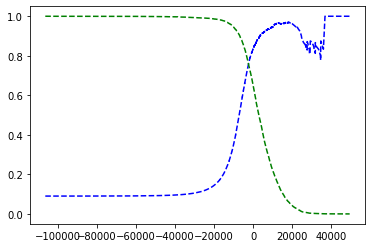

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") # len(thresholds) = len(precisions) - 1
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

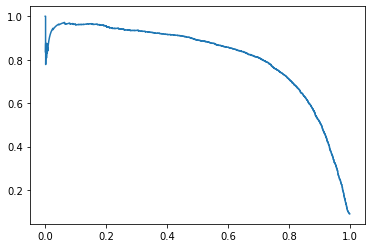

In [23]:
plt.plot(recalls, precisions)

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439557


In [25]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print( precision_score(y_train_5, y_train_pred_90) )
print( recall_score(y_train_5, y_train_pred_90) )

0.9000345901072293
0.4799852425751706


## The ROC Curve

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

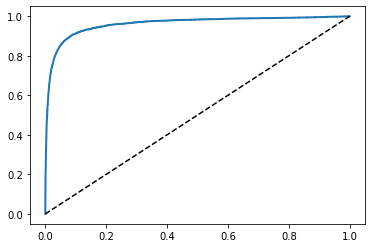

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # Dashed diagonal
    
plot_roc_curve(fpr, tpr)
plt.show()

In [28]:
# ROC AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [29]:
# from sklearn.ensemble import RandomForestClassifier

# forest_clf = RandomForestClassifier(random_state=42)
# y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [30]:
# y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
# fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [31]:
# plt.plot(fpr, tpr, "b:", label="SGD")
# plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
# plt.legend(loc="lower right")
# plt.show()

In [32]:
# roc_auc_score(y_train_5, y_scores_forest)

# Multiclass Classification

In [33]:
from sklearn.svm import SVC

svm_clf = SVC()

In [34]:
# svm_clf.fit(X_train, y_train)
# svm_clf.predict([some_digit])
# some_digit_scores = svm_clf.decision_function([some_digit])
# some_digit_scores

In [35]:
# np.argmax(some_digit_scores)

In [36]:
# svm_clf.classes_

In [37]:
# svm_clf.classes_[5]

In [38]:
# from sklearn.multiclass import OneVsRestClassifier

# ovc_clf = OneVsRestClassifier( SVC() )
# ovc_clf.fit(X_train, y_train)

In [39]:
# print( ovc_clf.predict([some_digit]) )
# print( len(ovc_clf.estimators_))

In [40]:
# sgd_clf.fit(X_train, y_train)
# sgd_clf.predict([some_digit])

In [41]:
# # Evaluating
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [42]:
# # Preprocessing: scaling
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# Error Analysis

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

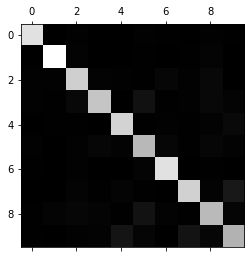

In [44]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [45]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums

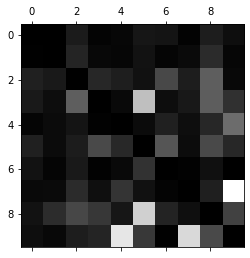

In [46]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilabel Classification

In [47]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [48]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [49]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Multioutput Classification

In [50]:
noise = np.random.randint(0, 100, (len(X_train), 784) )
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784) )
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [51]:
knn_clf.fit(X_train_mod, y_train_mod)
some_index = 5
clean_digit = knn_clf.predict([X_test_mod[some_index]])

In [52]:
plt.imshow(clean_digit, cmap="binary")
plt.axis("off")
plt.show()